In [1]:
using Turing, Distributions, DifferentialEquations, KernelDensity
using MCMCChains,CSV,DataFrames
#using StatsPlots
using StatsBase
import PyPlot
PyPlot.svg(true)
using LaTeXStrings

# Load data

In [8]:
mol_df = CSV.read("./../../experimental_data/processed_data/DSB_df.txt", DataFrame);
mol_df2 = CSV.read("./../../experimental_data/processed_data/NR-Cpf1-MolecularDATA.csv", DataFrame);
mol_df = vcat(mol_df,mol_df2,cols=:union);
mol_df[:,"experiment"] = mol_df[:,"defect"].*"_".*mol_df[:,"nuclease"];



micro_df = CSV.read("./../../experimental_data/processed_data/avg_data.csv", DataFrame);
remove_whitespace(str) = filter(x -> !isspace(x), str);
micro_df[:,"defect"] = remove_whitespace.(micro_df[:,"defect"])
micro_df[:,"nuclease"] = remove_whitespace.(micro_df[:,"nuclease"])
micro_df[:,"experiment"] = micro_df[:,"defect"].*"_".*micro_df[:,"nuclease"];
experiments = unique(micro_df.experiment)


8-element Vector{String}:
 "CGG_SpCas9"
 "CGG_Cpf1"
 "CTG_SpCas9"
 "CTG_Cpf1"
 "GAA_SpCas9"
 "GAA_Cpf1"
 "NR_SpCas9"
 "NR_Cpf1"

# Model definitions

In [9]:
function population_ode_model(du,u,p,t)
    m, b, r = u
    alpha, beta, rho, tlag   = p
    if t>tlag
        du[1] = (alpha-beta)*m 
        du[2] = beta*m - rho*b
        du[3] = alpha*r + rho*b 
    else
        du[1] = 0.0
        du[2] = 0.0
        du[3] = 0.0
    end
        
end
p0 = [0.003*60, 0.001*60, 0.006*60,5.]
u0 = [1.0,0.0,0.0]
prob = ODEProblem(population_ode_model,u0,(0.0,12.0),p0)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 12.0)
u0: 3-element Vector{Float64}:
 1.0
 0.0
 0.0

In [11]:
@model function molecular_model(data,prob)
    # fit model params from microfluidic data
    
    # priors
    sigma ~ truncated(Normal(1,3),0.,Inf) # experimental noise
    alpha ~ truncated(Normal(p0[1],1.),0.,Inf) # growth rate 
    beta ~ truncated(Normal(p0[2],1.),0,Inf) # break rate
    rho ~ truncated(Normal(p0[3],1.),0,Inf) # repair rate
    tlag ~ truncated(Normal(p0[4],4.),0,12.) # repair rate

    p = [alpha,beta,rho,tlag]
    prob = remake(prob,p=p)
    predicted = solve(prob,Tsit5(),saveat=collect(0:2.:12))

    for i = 1:length(predicted)
        u1 = predicted[i][2]/sum(predicted[i])
        u2 = predicted[i][3]/sum(predicted[i])
        data[i,1] ~ Normal(log(u1/(1-u1)), sigma)
        data[i,2] ~ Normal(log(u2/(1-u2)), sigma)
    end
end


    

molecular_model (generic function with 2 methods)

In [12]:
function inference_pipeline(nuclease,defect,outfile)
    
    # get data ready
    gfp = mol_df[(mol_df.defect .== defect).&(mol_df.nuclease .== nuclease),:gfp]./100.
    dsb = mol_df[(mol_df.defect .== defect).&(mol_df.nuclease .== nuclease),:dsb]./100.
    u0_data = [10e8*(1.0-gfp[1]-dsb[1]),10e8*dsb[1],10e8*gfp[1]]
    mol_times = mol_df[(mol_df.defect .== defect).&(mol_df.nuclease .== nuclease),:time]
    mol_odedata = hcat(dsb,gfp);
    
    defect_m = split(defect,"-")[1] # to handle multiple replicates of DSB 
    bf = micro_df[(micro_df.defect .== defect_m).&(micro_df.nuclease .== nuclease),:bf]
    gfp = micro_df[(micro_df.defect .== defect_m).&(micro_df.nuclease .== nuclease),:gfp]
    frac = gfp ./ bf
    micro_times =  micro_df[(micro_df.defect .== defect_m).&(micro_df.nuclease .== nuclease),:time]/60.
    micro_odedata = hcat(bf,gfp);
    
    # run inference on molecular data
    
    p0 = [0.003*60, 0.002*60, 0.006*60,5.0]
    fitmodel = molecular_model(mol_odedata,ODEProblem(population_ode_model,u0_data,(0.0,12.0),p0))
    @time chain = mapreduce(c -> sample(fitmodel, NUTS(.65),1000), chainscat, 1:3)
    
    # ------------------------------------------------------------------------------------------
    # save dataframe with chain information 
    chain_df = DataFrame(chain)
    CSV.write(outfile*"_chain.csv",chain_df)
    
    # ------------------------------------------------------------------------------------------
    # plot posterior distribution of alpha,beta,rho,lag ...  
    fig,axs = PyPlot.plt.subplots(nrows = 3,figsize=(5,4))
    PyPlot.plt.tight_layout()
    ax = axs[1]
    U = kde(vcat(Array(chain[:beta])...))
    ax.plot(U.x,U.density,label=L"\beta")
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
    ax.set_xlabel("1/hours")


    U = kde(vcat(Array(chain[:rho])...))
    ax.plot(U.x,U.density,label=L"\rho")

    prior = rand(truncated(Normal(p0[3],1.),0,Inf),10^5)
    U = kde(prior)
    ax.plot(U.x,U.density,"k--",label="prior")
    ax.set_xlim([0,3])
    ax.legend(frameon=false)


    ax = axs[2]
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
    U = kde(vcat(Array(chain[:alpha])...))
    ax.plot(U.x,U.density,label=L"\alpha")


    prior = rand(truncated(Normal(p0[1],1.),0,Inf),10^5)
    U = kde(prior)
    ax.plot(U.x,U.density,"k--",label="prior")

    ax.legend(frameon=false)
    ax.set_xlabel("1/hours")


    ax = axs[3]
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
    U = kde(vcat(Array(chain[:tlag])...))
    ax.plot(U.x,U.density,label=L"\tau_{\rm lag}")

    prior = rand(truncated(Normal(p0[4],4.),0,Inf),10^6)
    U = kde(prior)
    ax.plot(U.x,U.density,"k--",label="prior")

    ax.legend(frameon=false)
    ax.set_xlabel("hours")

    PyPlot.plt.savefig(outfile*"_posterior_params.svg",bbox_inches="tight")
    
    # ------------------------------------------------------------------------------------------
    # plot posterior predictive distribution compared to molecular data
    
    fig,axs = PyPlot.plt.subplots(ncols=2,figsize=(10,3))
    ax = axs[1]
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
    ax.plot(mol_times,mol_odedata[:,1],"C0o",label = "fraction broken",fillstyle="none")
    chain_array = Array(chain)
    for k in 1:30
        p = chain_array[rand(1:1500), 1:5]
        prob_rep = ODEProblem(population_ode_model,u0_data,(0.0,12.0),[p[1],p[2],p[3],p[5]])
        sol = solve(prob_rep,Tsit5(),saveat=0.1)
        gfp_rep = [sol.u[i][3] for i in 1:length(sol.u)]
        dsb_rep = [sol.u[i][2] for i in 1:length(sol.u)]
        bf_rep = [sum(sol.u[i]) for i in 1:length(sol.u)]
        ax.plot(sol.t,dsb_rep ./bf_rep,"C0-",alpha=0.2)
        
        # save ode simulations
        CSV.write(outfile*"_dsb_ode_sol_$k.csv",DataFrame([gfp_rep,bf_rep,dsb_rep],:auto))
        
    end
    ax.set_xlabel("hours")
    ax.legend(frameon=false)


    ax = axs[2]
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
    ax.plot(mol_times,mol_odedata[:,2],"C1o",label = "fraction repaired",fillstyle="none")
    chain_array = Array(chain)
    for k in 1:30
        p = chain_array[rand(1:1500), 1:5]
        prob_rep = ODEProblem(population_ode_model,u0_data,(0.0,12.0),[p[1],p[2],p[3],p[5]])
        sol = solve(prob_rep,Tsit5(),saveat=0.1)
        gfp_rep = [sol.u[i][3] for i in 1:length(sol.u)]
        dsb_rep = [sol.u[i][2] for i in 1:length(sol.u)]
        bf_rep = [sum(sol.u[i]) for i in 1:length(sol.u)]
        ax.plot(sol.t,gfp_rep ./bf_rep,"C1-",alpha=0.2)
    end
    ax.set_xlabel("hours")
    ax.legend(frameon=false)
    PyPlot.plt.savefig(outfile*"_posterior_predict_w_molecular.svg",bbox_inches="tight")
    
    # ------------------------------------------------------------------------------------------
    # plot posterior predictive distribution compared to bulk microfluidic data
    fig,ax = PyPlot.plt.subplots(figsize=(7,3))

    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
    chain_array = Array(chain)
    lags = []
    for k in 1:20
        p = chain_array[rand(1:1500), 1:5]
        prob_rep = ODEProblem(population_ode_model,[micro_odedata[1,1],0.0,micro_odedata[1,2]],(0.0,24.0),[p[1],p[2],p[3],p[5]])
        sol = solve(prob_rep,Tsit5(),saveat = micro_times)
        gfp_rep = [sol.u[i][3] for i in 1:length(sol.u)]
        dsb_rep = [sol.u[i][2] for i in 1:length(sol.u)]
        bf_rep = [sum(sol.u[i]) for i in 1:length(sol.u)]
        frac_rep = (gfp_rep ./ bf_rep)
        ax.plot(sol.t,gfp_rep ./ bf_rep,"C0-",alpha=0.2)
        
        # save ode simulations
        CSV.write(outfile*"_ode_sol_$k.csv",DataFrame([gfp_rep,bf_rep,dsb_rep],:auto))

        lag_ind = argmin([mean((frac_rep[1:end-(k-1)] .-frac[k:end]).^2) for k in 1:length(frac)-1])
        push!(lags,micro_times[lag_ind])
    end
    CSV.write(outfile*"_lags.csv",DataFrame([lags],:auto))
    ax.plot(micro_times .- mean(lags),frac,"C0o",label="fraction GFP",fillstyle="none")
    ax.set_xlabel("hours")
    ax.legend(frameon=false)
    PyPlot.plt.savefig(outfile*"_posterior_predict_w_microfluidic.svg",bbox_inches="tight")
    
    
end

inference_pipeline (generic function with 1 method)

# Run pipeline on data

In [ ]:
for experiment in unique(mol_df[:,:experiment])
    nuclease = mol_df[mol_df.experiment .== experiment,:nuclease][1]
    defect = mol_df[mol_df.experiment .== experiment,:defect][1]
    outfile = "./output/"*defect*"_"*nuclease
    println(outfile)
    inference_pipeline(nuclease,defect,outfile)
end

./output/CTG_Cpf1


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:18
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling:  14%|█████▊                                   |  ETA: 0:00:17┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /home/elevien/.julia/packages/SciMLBase/UIp7W/src/integrator_interface.jl:331
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:38
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:35


137.237972 seconds (815.36 M allocations: 60.545 GiB, 5.87% gc time, 0.09% compilation time)
./output/GAA_Cpf1


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ SciMLBase /home/elevien/.julia/packages/SciMLBase/UIp7W/src/integrator_interface.jl:331
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:55
┌ Info: Found initial step size
│   ϵ = 0.037500000000000006
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:22
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:49


128.572420 seconds (993.76 M allocations: 74.721 GiB, 6.69% gc time)
./output/CGG_Cpf1


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:43
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:55
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:24


123.115669 seconds (942.49 M allocations: 71.614 GiB, 6.74% gc time)
./output/NR_Cpf1


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:13
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/elevien/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
Sampling:  12%|████▊                                    |  ETA: 0:00:34

# Test on fake data

In [26]:
p_fake = [0.003*60, 0.002*60, 0.006*60,5.0]
u0 = [10000.0,0.0,0.0,0.0]
@time fake_sol = solve(remake(prob1,u0=u0,p = p_fake),Tsit5(),saveat=2);
sol_data = hcat([[fake_sol[i][2]/sum(fake_sol[i]),fake_sol[i][3]/sum(fake_sol[i])] for i in 1:length(fake_sol)]...)';
fake_odedata = sol_data +rand(Normal(0.0,0.02),size(sol_data))
scatter(fake_sol.t,fake_odedata[:,1],label = "fraction broken",grid=false,color=1)
scatter!(fake_sol.t,fake_odedata[:,2],label = "fraction repaired",color=2)
plot!(fake_sol.t,sol_data[:,1],label=false,color=1)
plot!(fake_sol.t,sol_data[:,2],label=false,color=2)
plot!(size=(500,200),legend=(0.1,0.9),foreground_color_legend = nothing,xlabel="time [hours]")

LoadError: [91mUndefVarError: prob1 not defined[39m

In [27]:
fitmodel = molecular_model(fake_odedata,ODEProblem(population_ode_model,u0,(0.0,12.0),p_fake))

LoadError: [91mUndefVarError: fake_odedata not defined[39m

In [28]:
@time chain = mapreduce(c -> sample(fitmodel, NUTS(.65),1000), chainscat, 1:3)

LoadError: [91mUndefVarError: fitmodel not defined[39m

In [36]:
@df chain cornerplot([:alpha :beta :rho :sigma :tlag],compact=true)

In [146]:
chai

Chains MCMC chain (1000×17×3 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 1000
parameters        = alpha, beta, rho, sigma, tlag
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

       alpha    0.6427    0.3970     0.0072    0.0220   255.4662    1.0133
        beta    0.2051    0.0634     0.0012    0.0037   235.4011    1.0157
         rho    0.2626    0.0613     0.0011    0.0035   292.3500    1.0126
       sigma    0.0255    0.0065     0.0001    0.0003   415.0081    1.0135
        tlag    5.0634    0.3585     0.0065    0.0153   423.9287    1.0053

Quantiles
  parameters      2.5%     25.0%    

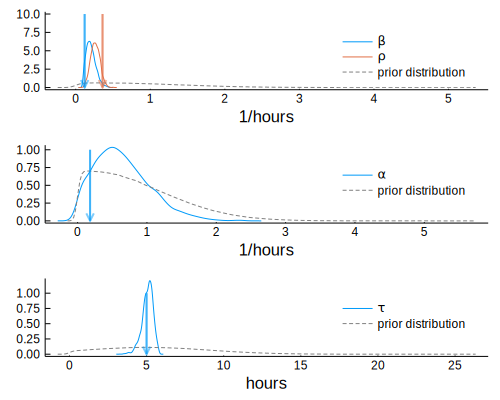

In [37]:
#@df chain density(:alpha)
@df chain density(:beta, label = "\\beta")
@df chain density!(:rho,label = "\\rho")
@df chain density!(rand(truncated(Normal(p0[3],1.),0,Inf),10^5),label="prior distribution"
    ,color="Gray",linestyle = :dash)
plot!([p_fake[2],p_fake[2]],[10,0],color=1,linewidth=2,label=false,arrow=true,linealpha=0.5)
plot!([p_fake[3],p_fake[3]],[10,0],color=2,linewidth=2,label=false,arrow=true,linealpha=0.5)

p1 = plot!(size=(500,400),grid=false,xlabel = "1/hours",foreground_color_legend = nothing)


@df chain density(:alpha,label = "\\alpha")
@df chain density!(rand(truncated(Normal(p0[1],1.),0,Inf),10^6),label="prior distribution"
    ,color="Gray",linestyle = :dash)
plot!([p_fake[1],p_fake[1]],[1,0],color=1,linewidth=2,label=false,arrow=true,linealpha=0.5)

p2 = plot!(size=(500,400),grid=false,xlabel = "1/hours",foreground_color_legend = nothing)



@df chain density(:tlag,label = "\\tau")
@df chain density!(rand(truncated(Normal(p0[4],4.),0,Inf),10^6),label="prior distribution"
    ,color="Gray",linestyle = :dash)
plot!([p_fake[4],p_fake[4]],[1,0],color=1,linewidth=2,label=false,arrow=true,linealpha=0.5)

p3 = plot!(size=(500,400),grid=false,xlabel = "hours",foreground_color_legend = nothing)


plot(p1,p2,p3,layout=(3,1))

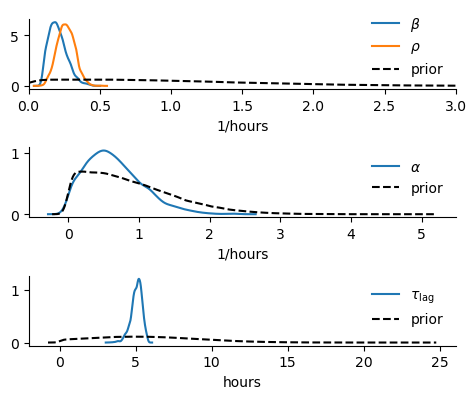

In [178]:
fig,axs = PyPlot.plt.subplots(nrows = 3,figsize=(5,4))
PyPlot.plt.tight_layout()
ax = axs[1]
U = kde(vcat(Array(chain[:beta])...))
ax.plot(U.x,U.density,label=L"\beta")
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.set_xlabel("1/hours")


U = kde(vcat(Array(chain[:rho])...))
ax.plot(U.x,U.density,label=L"\rho")

prior = rand(truncated(Normal(p0[3],1.),0,Inf),10^5)
U = kde(prior)
ax.plot(U.x,U.density,"k--",label="prior")
ax.set_xlim([0,3])
ax.legend(frameon=false)


ax = axs[2]
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
U = kde(vcat(Array(chain[:alpha])...))
ax.plot(U.x,U.density,label=L"\alpha")


prior = rand(truncated(Normal(p0[1],1.),0,Inf),10^5)
U = kde(prior)
ax.plot(U.x,U.density,"k--",label="prior")

ax.legend(frameon=false)
ax.set_xlabel("1/hours")


ax = axs[3]
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
U = kde(vcat(Array(chain[:tlag])...))
ax.plot(U.x,U.density,label=L"\tau_{\rm lag}")

prior = rand(truncated(Normal(p0[4],4.),0,Inf),10^6)
U = kde(prior)
ax.plot(U.x,U.density,"k--",label="prior")

ax.legend(frameon=false)
ax.set_xlabel("hours")

PyPlot.plt.tight_layout()

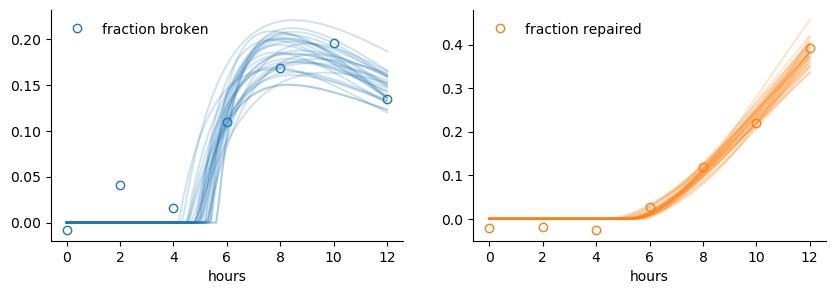

In [194]:

#scatter!(mol_times,mol_odedata[:,2],label = "fraction repaired",color=2)
fig,axs = PyPlot.plt.subplots(ncols=2,figsize=(10,3))
ax = axs[1]
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.plot(mol_times,fake_odedata[:,1],"C0o",label = "fraction broken",fillstyle="none")
chain_array = Array(chain)
for k in 1:30
    p = chain_array[rand(1:1500), 1:5]
    prob_rep = ODEProblem(population_ode_model,[1.0,0.0,0.0],(0.0,12.0),[p[1],p[2],p[3],p[5]])
    sol = solve(prob_rep,Tsit5(),saveat=0.1)
    gfp_rep = [sol.u[i][3] for i in 1:length(sol.u)]
    dsb_rep = [sol.u[i][2] for i in 1:length(sol.u)]
    bf_rep = [sum(sol.u[i]) for i in 1:length(sol.u)]
    ax.plot(sol.t,dsb_rep ./bf_rep,"C0-",alpha=0.2)
end
ax.set_xlabel("hours")
ax.legend(frameon=false)


ax = axs[2]
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.plot(mol_times,fake_odedata[:,2],"C1o",label = "fraction repaired",fillstyle="none")
chain_array = Array(chain)
for k in 1:30
    p = chain_array[rand(1:1500), 1:5]
    prob_rep = ODEProblem(population_ode_model,[1.0,0.0,0.0],(0.0,12.0),[p[1],p[2],p[3],p[5]])
    sol = solve(prob_rep,Tsit5(),saveat=0.1)
    gfp_rep = [sol.u[i][3] for i in 1:length(sol.u)]
    dsb_rep = [sol.u[i][2] for i in 1:length(sol.u)]
    bf_rep = [sum(sol.u[i]) for i in 1:length(sol.u)]
    ax.plot(sol.t,gfp_rep ./bf_rep,"C1-",alpha=0.2)
end
ax.set_xlabel("hours")
ax.legend(frameon=false)

PyPlot.plt.savefig("text.svg",bbox_inches="tight")

# Apply to real data

In [9]:
gfp = mol_df[(mol_df.defect .== defect).&(mol_df.nuclease .== nuclease),:gfp]./100.
dsb = mol_df[(mol_df.defect .== defect).&(mol_df.nuclease .== nuclease),:dsb]./100.
mol_odedata = hcat(dsb,gfp);

LoadError: [91mUndefVarError: defect not defined[39m

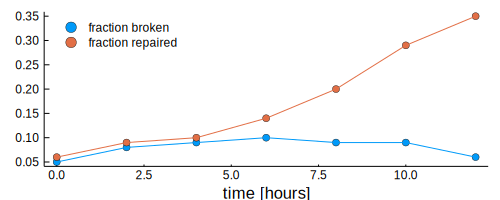

In [198]:
scatter(mol_times,mol_odedata[:,1],label = "fraction broken",grid=false,color=1)
scatter!(mol_times,mol_odedata[:,2],label = "fraction repaired",color=2)
plot!(mol_times,mol_odedata[:,1],label=false,color=1)
plot!(mol_times,mol_odedata[:,2],label=false,color=2)
plot!(size=(500,200),legend=(0.1,0.9),foreground_color_legend = nothing,xlabel="time [hours]")

In [203]:
u0_data = [10e8*(1.0-gfp[1]-dsb[1]),10e8*dsb[1],10e8*gfp[1]]
fitmodel = molecular_model(mol_odedata,ODEProblem(population_ode_model,u0,(0.0,12.0),p_fake))
@time chain = mapreduce(c -> sample(fitmodel, NUTS(.65),1000), chainscat, 1:3)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/E/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /Users/E/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /Users/E/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /Users/E/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/E/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /Users/E/.julia/packages/DiffEqBase/V7P18/src/integrator_interface.jl:329
┌ Info: Found initial step 

379.533843 seconds (1.98 G allocations: 93.095 GiB, 6.67% gc time)


Chains MCMC chain (1000×17×3 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 1000
parameters        = alpha, beta, rho, sigma, tlag
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

       alpha    0.8379    0.4903     0.0090    0.0307   199.1896    1.0106
        beta    0.1114    0.0375     0.0007    0.0026   165.2509    1.0146
         rho    0.3181    0.1422     0.0026    0.0107   184.3465    1.0157
       sigma    0.0367    0.0086     0.0002    0.0004   310.7707    1.0065
        tlag    0.6497    0.6530     0.0119    0.0411   220.6770    1.0232

Quantiles
  parameters      2.5%     25.0%    

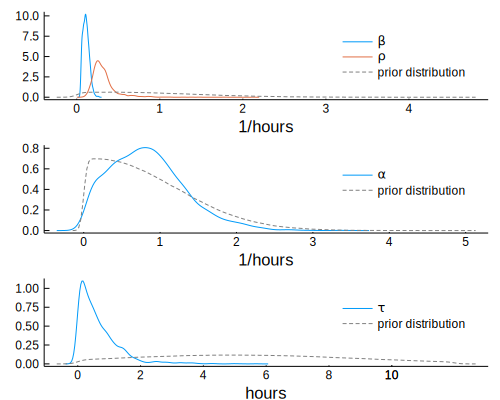

In [205]:
@df chain density(:beta, label = "\\beta")
@df chain density!(:rho,label = "\\rho")
@df chain density!(rand(truncated(Normal(p0[3],1.),0,Inf),10^5),label="prior distribution"
    ,color="Gray",linestyle = :dash)


p1 = plot!(size=(500,400),grid=false,xlabel = "1/hours",foreground_color_legend = nothing)


@df chain density(:alpha,label = "\\alpha")
@df chain density!(rand(truncated(Normal(p0[1],1.),0,Inf),10^6),label="prior distribution"
    ,color="Gray",linestyle = :dash)


p2 = plot!(size=(500,400),grid=false,xlabel = "1/hours",foreground_color_legend = nothing)



@df chain density(:tlag,label = "\\tau")
@df chain density!(rand(truncated(Normal(p0[4],4.),0,12),10^6),label="prior distribution"
    ,color="Gray",linestyle = :dash)

p3 = plot!(size=(500,400),grid=false,xlabel = "hours",foreground_color_legend = nothing)


plot(p1,p2,p3,layout=(3,1))
#savefig(outfolder*"/posterior.pdf")
plot!()

3000×19 DataFrame
  Row │ iteration  chain  acceptance_rate  alpha       beta       hamiltonian_ ⋯
      │ Int64      Int64  Float64          Float64     Float64    Float64      ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │         1      1        0.185691   0.454697    0.161114             -2 ⋯
    2 │         2      1        0.149598   0.40218     0.160639             -2
    3 │         3      1        0.526387   0.35831     0.167369             -2
    4 │         4      1        0.763535   0.388234    0.152802             -2
    5 │         5      1        0.951719   0.223227    0.134978             -2 ⋯
    6 │         6      1        0.599186   0.447015    0.165801             -2
    7 │         7      1        0.270463   0.28288     0.153824             -2
    8 │         8      1        0.216628   0.290219    0.151058             -2
    9 │         9      1        0.384789   0.0967752   0.125178             -2 ⋯
   10 │        10      1        0.751949   0.0849195   0.122283             -2
   11 │        11      1        0.951381   0.295189    0.172689             -1
  ⋮   │     ⋮        ⋮           ⋮             ⋮           ⋮              ⋮    ⋱
 2991 │       991      3        0.851876   0.0143659   0.10176              -2
 2992 │       992      3        0.8048     0.00215653  0.111296             -1 ⋯
 2993 │       993      3        0.510253   0.00125621  0.0970713            -1
 2994 │       994      3        0.817641   0.00402741  0.106445             -1
 2995 │       995      3        0.997285   0.0388828   0.113934             -2
 2996 │       996      3        0.284598   0.095682    0.127391             -1 ⋯
 2997 │       997      3        0.870752   0.176961    0.123102             -2
 2998 │       998      3        0.820744   0.214384    0.124016             -2
 2999 │       999      3        0.0717817  0.215568    0.117677             -2
 3000 │      1000      3        0.998318   0.199922    0.123819             -2 ⋯
                                                14 columns and 2979 rows omitted

In [290]:
u0_data./sum(u0_data)

3-element Array{Float64,1}:
 0.76
 0.04
 0.2

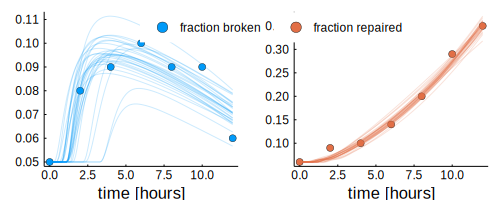

In [304]:

#scatter!(mol_times,mol_odedata[:,2],label = "fraction repaired",color=2)

scatter(mol_times,mol_odedata[:,1],label = "fraction broken",grid=false,color=1)
chain_array = Array(chain)
for k in 1:30
    p = chain_array[rand(1:1500), 1:5]
    prob_rep = ODEProblem(dna_model,u0_data,(0.0,12.0),[p[1],p[2],p[3],p[5]])
    sol = solve(prob_rep,Tsit5(),saveat=0.1)
    gfp_rep = [sol.u[i][3] for i in 1:length(sol.u)]
    dsb_rep = [sol.u[i][2] for i in 1:length(sol.u)]
    bf_rep = [sum(sol.u[i]) for i in 1:length(sol.u)]
    #plot!(sol.t,gfp_rep ./bf_rep,color=2,linealpha=0.2,label=false)
    plot!(sol.t,dsb_rep ./bf_rep,color=1,linealpha=0.2,label=false)
end

p1 = plot!(size=(500,200),legend=(0.7,0.9),foreground_color_legend = nothing,xlabel="time [hours]")

scatter(mol_times,mol_odedata[:,2],label = "fraction repaired",color=2,grid=false)
chain_array = Array(chain)
for k in 1:30
    p = chain_array[rand(1:1500), 1:5]
    prob_rep = ODEProblem(dna_model,u0_data ,(0.0,12.0),[p[1],p[2],p[3],p[5]])
    sol = solve(prob_rep,Tsit5(),saveat=0.1)
    gfp_rep = [sol.u[i][3] for i in 1:length(sol.u)]
    dsb_rep = [sol.u[i][2] for i in 1:length(sol.u)]
    bf_rep = [sum(sol.u[i]) for i in 1:length(sol.u)]
    plot!(sol.t,gfp_rep ./bf_rep,color=2,linealpha=0.2,label=false)
end

p2 = plot!(size=(500,200),legend=(0.1,0.9),foreground_color_legend = nothing,xlabel="time [hours]")
plot(p1,p2,layout = (1,2))
savefig(outfolder*"/posterior_predictions.pdf")
plot!()

In [196]:
lag_ind = argmin([mean((frac_rep[1:end-(k-1)] .-frac[k:end]).^2) for k in 1:length(frac)-1])

LoadError: ArgumentError: collection must be non-empty

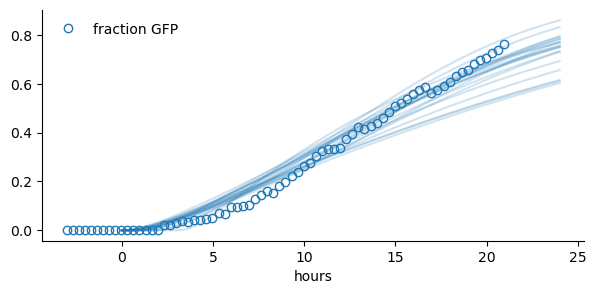

PyObject <matplotlib.legend.Legend object at 0x7f89899bf2e8>

In [238]:
fig,ax = PyPlot.plt.subplots(figsize=(7,3))

ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
chain_array = Array(chain)
lags = []
for k in 1:20
    p = chain_array[rand(1:1500), 1:5]
    prob_rep = ODEProblem(population_ode_model,[micro_odedata[1,1],0.0,micro_odedata[1,2]],(0.0,24.0),[p[1],p[2],p[3],p[5]])
    sol = solve(prob_rep,Tsit5(),saveat=micro_times)
    gfp_rep = [sol.u[i][3] for i in 1:length(sol.u)]
    dsb_rep = [sol.u[i][2] for i in 1:length(sol.u)]
    bf_rep = [sum(sol.u[i]) for i in 1:length(sol.u)]
    frac_rep = (gfp_rep ./ bf_rep)
    ax.plot(sol.t,gfp_rep ./ bf_rep,"C0-",alpha=0.2)
    
    lag_ind = argmin([mean((frac_rep[1:end-(k-1)] .-frac[k:end]).^2) for k in 1:length(frac)-1])
    push!(lags,micro_times[lag_ind])
end

ax.plot(micro_times .- mean(lags),frac,"C0o",label="fraction GFP",fillstyle="none")
ax.set_xlabel("hours")
ax.legend(frameon=false)


In [233]:
micro_odedata

73×2 Array{Union{Missing, Float64},2}:
  1.0       0.0
  1.0       0.0
  1.0       0.0
  1.0       0.0
  1.0       0.0
  1.0       0.0
  1.01471   0.0
  1.07353   0.0
  1.08824   0.0
  1.10294   0.0
  1.10294   0.0
  1.13235   0.0
  1.17647   0.0
  ⋮        
 28.2206   16.2206
 29.9706   17.7353
 31.75     19.3382
 33.4412   21.1765
 35.8235   23.2353
 37.2059   24.5
 38.9265   26.5882
 41.4559   28.9118
 43.3088   30.6176
 45.9559   33.4265
 48.5882   35.8382
 51.6765   39.5588

In [209]:
[micro_odedata[1,1],0.0,micro_odedata[1,2]]

LoadError: BoundsError: attempt to access 0×2 Array{Union{Missing, Float64},2} at index [1, 1]

## look at posterior prediction distribution

In [271]:
fits_df = CSV.read("./output/fits_summary.csv", DataFrame);
fits_df

9×9 DataFrame
 Row │ Column1  Unnamed: 0  experiment       defect  nuclease  alpha_populatio ⋯
     │ Int64    Int64       String           String  String    Float64         ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │       0           0  NR-SpCas9        NR      SpCas9          0.0038528 ⋯
   2 │       1           1  CTG-Cpf1         CTG     Cpf1            0.0038701
   3 │       2           2  CGG-Cpf1         CGG     Cpf1            0.0035746
   4 │       3           3  NoGuideRNA       none    none            0.0040199
   5 │       4           4  GAA-SpCas9-comb  GAA     SpCas9          0.0018229 ⋯
   6 │       5           5  GAA - Cpf1       GAA      Cpf1           0.0037836
   7 │       6           6  CTG-SpCas9-comb  CTG     SpCas9          0.0024802
   8 │       7           7  CGG-SpCas9       CGG     SpCas9          0.0038710
   9 │       8           8  NR-Cpf1-comb     NR      Cpf1            0.0041035 ⋯
                                                               4 columns omitted

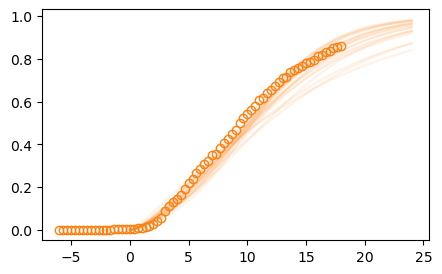

In [323]:
fig,ax = PyPlot.plt.subplots(figsize=(5,3))

#ax.plot(micro_times,,"C0o",lstyle="none")
ax.plot(micro_times.-6.,micro_odedata[:,2] ./ micro_odedata[:,1],"C1o",fillstyle="none")

#PyPlot.plt.plot(times,gfp,"o-",fillstyle="none")
chain_array = Array(chain)
for k in 1:20
    p = chain_array[rand(1:1500), 1:3]
    prob_rep = ODEProblem(dna_model,[1.0,0.0,0.0],(0.0,24.0),[p[1],p[2],p[3]])
    sol = solve(prob_rep,Tsit5(),saveat=0.1)
    gfp_rep = [sol.u[i][3] for i in 1:length(sol.u)]
    dsb_rep = [sol.u[i][2] for i in 1:length(sol.u)]
    bf_rep = [sum(sol.u[i]) for i in 1:length(sol.u)]
    #ax.plot(sol.t ,,"C0-",alpha=0.1)
    ax.plot(sol.t,gfp_rep ./ bf_rep,"C1-",alpha=0.1
en


In [283]:
fits_df

9×9 DataFrame
 Row │ Column1  Unnamed: 0  experiment       defect  nuclease  alpha_populatio ⋯
     │ Int64    Int64       String           String  String    Float64         ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │       0           0  NR-SpCas9        NR      SpCas9          0.0038528 ⋯
   2 │       1           1  CTG-Cpf1         CTG     Cpf1            0.0038701
   3 │       2           2  CGG-Cpf1         CGG     Cpf1            0.0035746
   4 │       3           3  NoGuideRNA       none    none            0.0040199
   5 │       4           4  GAA-SpCas9-comb  GAA     SpCas9          0.0018229 ⋯
   6 │       5           5  GAA - Cpf1       GAA      Cpf1           0.0037836
   7 │       6           6  CTG-SpCas9-comb  CTG     SpCas9          0.0024802
   8 │       7           7  CGG-SpCas9       CGG     SpCas9          0.0038710
   9 │       8           8  NR-Cpf1-comb     NR      Cpf1            0.0041035 ⋯
                                                               4 columns omitted

In [210]:
log(2)/(0.0038*60)

3.040119212982216

In [319]:
write("test_chain.jls",chain)

In [320]:
chain[:beta]

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:1000
    :chain, 1:3
And data, a 1000×3 Array{Float64,2}:
 0.200896  0.173081  0.171294
 0.165733  0.211779  0.179959
 0.228833  0.228607  0.140116
 0.237235  0.245055  0.193289
 0.263377  0.217062  0.18069
 0.278766  0.246112  0.199403
 0.190739  0.250642  0.181966
 0.178566  0.137025  0.1703
 0.17291   0.193192  0.165432
 0.171587  0.200921  0.17327
 0.169499  0.2032    0.13554
 0.131081  0.184651  0.135572
 0.125602  0.195747  0.165043
 ⋮                   
 0.147314  0.227723  0.13691
 0.144995  0.230919  0.126919
 0.157994  0.202797  0.129268
 0.139685  0.208994  0.180622
 0.123976  0.227175  0.165856
 0.12384   0.189136  0.166298
 0.120857  0.172306  0.12402
 0.112614  0.158563  0.115443
 0.142994  0.1681    0.125749
 0.199278  0.171847  0.127189
 0.195047  0.127825  0.119173
 0.17748   0.130004  0.122355